In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/profile-data/dump.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,cm
import random
import operator
from functools import reduce


In [3]:
def michalewicz(x):
    result = reduce(lambda acc, x: acc + np.sin(x) * np.power(np.sin((0 + 1) * np.power(x, 2) / np.pi), 2 * 10), x, 0.)
    return -1.0*result

In [4]:
def ackley(x):
    return -20*np.exp(-0.2*np.sqrt((x[0]**2+x[1]**2)/2)) - np.exp(0.5*(np.cos(2*np.pi*x[0]) + np.cos(2*np.pi*x[1]))) + 20 + np.exp(1)

In [5]:
class Firefly():
    def __init__(self, alpha, beta, gamma, upper_boundary, lower_boundary, function_dimension):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.__intensity = None
        self.lower_boundary = lower_boundary
        self.upper_boundary = upper_boundary
        self.__position = np.array([random.uniform(self.lower_boundary, self.upper_boundary) for x in range(function_dimension)])
    
    
    @property
    def intensity(self):
        return self.__intensity

        
    @property
    def position(self):
        return self.__position
    
    @position.setter
    def position(self, value):
        self.__position = value

    def move_towards(self, better_position):
        # euclidean distance
        distance = np.linalg.norm(self.__position - better_position)
        self.__position = self.__position + self.beta*np.exp(-self.gamma*(distance**2)) * (better_position-self.__position) +  self.alpha*(random.uniform(0, 1)-0.5)
        self.check_boundaries()

    def random_walk(self, area):
        self.__position = np.array([random.uniform(cord-area, cord+area) for x, cord in np.ndenumerate(self.__position)])
    def update_intensity(self, func):
        self.__intensity = -1*func(self.__position)
    def check_boundaries(self):
        for i, cord in np.ndenumerate(self.__position):
            if cord < self.lower_boundary:
                self.__position[i] = self.lower_boundary
            elif cord > self.upper_boundary:
                self.__position[i] = self.upper_boundary
            else:
                self.__position[i] = cord


In [6]:
class FireflyProblem():
    
    def __init__(self, function, firefly_number, upper_boundary=5.12, lower_boundary=-5.12, alpha=2, beta=2, gamma=0.97, iteration_number=50, interval=500, continuous=False):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.function_dimension = 2
        self.upper_boundary = upper_boundary
        self.lower_boundary = lower_boundary
        self.iteration_number = iteration_number
        self.fireflies = [Firefly(self.alpha,self.beta,self.gamma,self.upper_boundary,self.lower_boundary, self.function_dimension) for x in range(firefly_number)]
        self.function = function
        self.interval = interval
        self.best = None
        self.continuous = continuous
        self.cost=[]
        i=0
        while i<(len(self.fireflies)): #Change to while
            (self.fireflies)[i].update_intensity(self.function)
            i+=1

    def run(self):
        y = np.linspace(self.lower_boundary, self.upper_boundary, 100)
        x = np.linspace(self.lower_boundary, self.upper_boundary, 100)
        X, Y = np.meshgrid(x, y)
        z = self.function([X, Y])        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r)  # pylint: disable=no-member
        fig.colorbar(cs)
        x_init = []
        y_init = []
        i=0
        while i<(len(self.fireflies)):#change to while
            x_init.append((self.fireflies)[i].position[0])
            y_init.append((self.fireflies)[i].position[1])
            i+=1
        particles, = ax.plot(x_init, y_init, 'ro', ms=6)
        rectangle = plt.Rectangle([self.lower_boundary, self.lower_boundary],self.upper_boundary-self.lower_boundary,self.upper_boundary-self.lower_boundary, ec='none', lw=2, fc='none')
        ax.add_patch(rectangle)
#         self.plot()

        def init():
            particles.set_data([], [])
            rectangle.set_edgecolor('none')
            return particles, rectangle

        def animate(i): #Generate animation and visualization
            x = []
            y = []
            ms = int(50. * fig.get_figwidth()/fig.dpi)
            rectangle.set_edgecolor('k')
            fig.canvas.set_window_title('Iteration %s/%s' % (i, self.iteration_number))
            if i ==0:
                print("reset the fireflies")
                self.best = None

            for idx, firefly in enumerate(self.fireflies):
                if i == 0:
                    firefly.__position = np.array([x_init[idx], y_init[idx]])
                    firefly.update_intensity(self.function)
                    fig.canvas.set_window_title('Initialization')
                x.append(firefly.position[0])
                y.append(firefly.position[1])
            self.step()
            particles.set_data(x, y)
            particles.set_markersize(ms)
            return particles, rectangle        
        graph = animation.FuncAnimation(fig, animate, frames=self.iteration_number+1, interval=self.interval, blit=True, init_func=init, repeat=self.continuous)
        plt.show()
        if (not self.best or self.fireflies[0].intensity > self.best):
            self.best = self.fireflies[0].intensity
        if(self.function==michalewicz):
            graph.save('firefly_michalewicz.gif')   
        elif(self.function==ackley):
            graph.save('firefly_ackley.gif')
    def step(self):
        (self.fireflies).sort(key=operator.attrgetter('intensity'), reverse=True)
        for i in self.fireflies:
            for j in self.fireflies:
                if j.intensity > i.intensity:
                    i.move_towards(j.position)
                    i.update_intensity(self.function)
     
        if (not self.best or (self.fireflies[0].intensity > self.best) ):
            self.best = self.fireflies[0].intensity
        if(self.function==michalewicz):
            gmin = -1.8013
            self.cost.append(abs(self.best - abs(gmin))/abs(gmin))
            print("Overall best intensity: {}, Overall best Accuracy: {}".format(self.best,100*abs(1-abs(self.best - gmin)/abs(gmin))))             
        elif(self.function==ackley):
            gmin = 0
            self.cost.append(abs(self.best - gmin))
            print("Overall best intensity: {}, Overall best Accuracy: {}".format(self.best,100*abs(1-abs(self.best - gmin))))
       
        (self.fireflies)[0].random_walk(0.1)
        (self.fireflies)[0].update_intensity(self.function)
    
    def plot(self):
        X_Axis=range(1,self.iteration_number+2)
        plt.plot(X_Axis,self.cost)
        plt.xlabel('No. of iterations')
        plt.ylabel('Cost')
        plt.show()
        

In [7]:
def run_firefly_algorithm(optimizer,fireflies_number = 40,upper_boundary=5.12, lower_boundary=-5.12, alpha=2, beta=2, gamma=0.97, iteration_number=10, interval=500):
    out = FireflyProblem(optimizer, fireflies_number,upper_boundary, lower_boundary, alpha, beta, gamma, iteration_number, interval)
    out.run()
    out.plot()

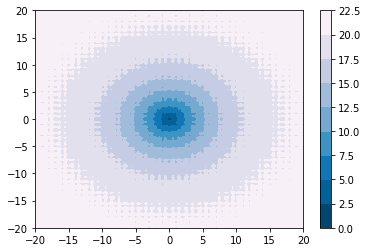

reset the fireflies
Overall best intensity: -10.365427530389642, Overall best Accuracy: 936.5427530389642
Overall best intensity: -10.156018532790126, Overall best Accuracy: 915.6018532790126
Overall best intensity: -9.713854699733337, Overall best Accuracy: 871.3854699733338
Overall best intensity: -9.713854699733337, Overall best Accuracy: 871.3854699733338
Overall best intensity: -9.713854699733337, Overall best Accuracy: 871.3854699733338
Overall best intensity: -9.713854699733337, Overall best Accuracy: 871.3854699733338
Overall best intensity: -9.713854699733337, Overall best Accuracy: 871.3854699733338
Overall best intensity: -6.665619934673124, Overall best Accuracy: 566.5619934673124
Overall best intensity: -6.665619934673124, Overall best Accuracy: 566.5619934673124
Overall best intensity: -4.081677173179205, Overall best Accuracy: 308.1677173179205
Overall best intensity: -4.081677173179205, Overall best Accuracy: 308.1677173179205
Overall best intensity: -3.930349994906639,

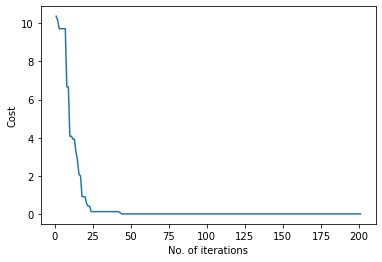

In [8]:
run_firefly_algorithm(ackley,40,20,-20,1,5,0.5,200,50)

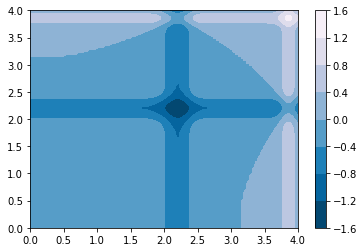

reset the fireflies
Overall best intensity: 0.6689503935583927, Overall best Accuracy: 37.13708952192265
Overall best intensity: 1.5548167212467527, Overall best Accuracy: 86.31636713744255
Overall best intensity: 1.5795847205587643, Overall best Accuracy: 87.69137403868119
Overall best intensity: 1.5795847205587643, Overall best Accuracy: 87.69137403868119
Overall best intensity: 1.5934770457108274, Overall best Accuracy: 88.46261287463652
Overall best intensity: 1.5934770457108274, Overall best Accuracy: 88.46261287463652
Overall best intensity: 1.6014231502204566, Overall best Accuracy: 88.90374453008698
Overall best intensity: 1.6014231502204566, Overall best Accuracy: 88.90374453008698
Overall best intensity: 1.6014231502204566, Overall best Accuracy: 88.90374453008698
Overall best intensity: 1.6014231502204566, Overall best Accuracy: 88.90374453008698
Overall best intensity: 1.6014231502204566, Overall best Accuracy: 88.90374453008698
Overall best intensity: 1.6014231502204566, O

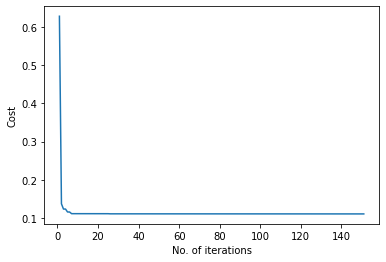

In [9]:
run_firefly_algorithm(michalewicz,40,4,0,1,5,0.5,150,100)

In [10]:
dataset = pd.read_csv('../input/profile-data/dump.csv',encoding='latin-1')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39537 entries, 0 to 39536
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             39537 non-null  int64  
 1   ageEstimate            39537 non-null  float64
 2   companyFollowerCount   38071 non-null  float64
 3   companyHasLogo         36407 non-null  object 
 4   companyName            39535 non-null  object 
 5   companyStaffCount      38401 non-null  float64
 6   companyUrl             37449 non-null  object 
 7   companyUrn             39537 non-null  object 
 8   connectionsCount       39537 non-null  float64
 9   country                39537 non-null  object 
 10  endDate                30626 non-null  object 
 11  followable             39537 non-null  float64
 12  followersCount         39537 non-null  float64
 13  genderEstimate         35567 non-null  object 
 14  hasPicture             29601 non-null  object 
 15  is

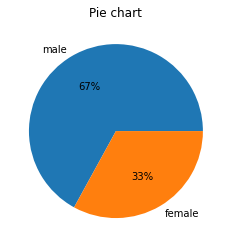

In [11]:
count_Class=pd.value_counts(dataset['genderEstimate'], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()